#### Student Name: Zheng Hanming
#### Student ID: 21225621

In [460]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import math
import random

df = pd.read_csv("./bank.csv")


#### ✔️ Subtask 1 - fill in all missing values

Columns with missing value, derived columns due to encoding are ignored
- job: 10 missing - *IMPUTE* because job cannot be missing as there is a category of unemployed
  * Impute with the most common job, this is a simple approach. It is not the best but there are only 10 missing values. Therefore, the impact of bias should not be huge
- education: 104 missing - *IMPUTE* because the minimum should be primary at least(for the vast of majority of the population)
  * Looking at the crosstab chart below, we can observe that ther are some clear relationship between job and education. 
  * With that, we can predict/impute education based on the job categories
- age: 12 missing - *IMPUTE* because age cannot be missing
  * Looking at the boxplot below, from left to right, every two boxes, are primary, secondary, tertiary. And within each pair of boxes, we have non-student and student. From the graph, we can see that 
    - As education level increase, if customer is a student then age increases - this makes sense as students of higher educations are generally older.
    - As education level increase, if customer is not a student then age decreases - this makes sense as older generation usually have lower education level.
  * With this, we can better predict/impute age by looking at these attributes.
- contact: 191 missing - *IMPUTE* because bank should always require at least one of customer contact
  * Looking at the crosstab below, we can see that yound adults seldom use telephone. And for older generation, they are more likely(probability) to use telephone.
  * The values are imputed using probability for different age groups
- balance: 87 invalid - *NOT IMPUTE* because 0 or negative balance(I guess) is possible
- pdays: 454 invalid - *NOT IMPUTE* because -1 indicated never contacted
- previous: 454 invalid - *NOT IMPUTE* because 0 indicated never contacted
- poutcome: 454 missing - *NOT IMPUTE* because na indicated never contacted

Legend: Invalid: 0 or -1 | Missing: value not present

In [461]:
def print_missing_columns():
    print("--- Summarize Columns With Missing Values ---")
    for col in df:
        if '_' not in col:
            # reason we ignore column with header name that contains _ is because those are derived columns
            # we know this by reading the output of encoding and original columns do not contain _
            print(
                f'{col}: Missing({df[col].isna().sum()}) | Possibly Invalid Value({df[col].isin([0, -1]).sum()})')


In [462]:
print_missing_columns()

--- Summarize Columns With Missing Values ---
age: Missing(12) | Possibly Invalid Value(0)
job: Missing(10) | Possibly Invalid Value(0)
marital: Missing(0) | Possibly Invalid Value(0)
education: Missing(104) | Possibly Invalid Value(0)
default: Missing(0) | Possibly Invalid Value(0)
balance: Missing(0) | Possibly Invalid Value(87)
housing: Missing(0) | Possibly Invalid Value(0)
loan: Missing(0) | Possibly Invalid Value(0)
contact: Missing(191) | Possibly Invalid Value(0)
day: Missing(0) | Possibly Invalid Value(0)
month: Missing(0) | Possibly Invalid Value(0)
duration: Missing(0) | Possibly Invalid Value(0)
campaign: Missing(0) | Possibly Invalid Value(0)
pdays: Missing(0) | Possibly Invalid Value(454)
previous: Missing(0) | Possibly Invalid Value(454)
poutcome: Missing(454) | Possibly Invalid Value(0)
subscribed: Missing(0) | Possibly Invalid Value(0)


In [463]:
# IMPUTE JOB
df['job'].fillna(df['job'].mode()[0], inplace=True)


In [464]:
# IMPUTE EDUCATION
crosstab_CL = pd.crosstab(df['job'], df['education'])
crosstab_CL.plot(kind='bar', stacked=True)
plt.ylabel('Number of Customers')
plt.xlabel('Job')
plt.show()


unique_jobs = df.job.unique()
job_edu_map = {}

for job in unique_jobs:
    entries_for_job = df[df['job'] == job]
    most_common_edu_for_job = entries_for_job['education'].mode()[0]
    job_edu_map[job] = most_common_edu_for_job

# fill in education based on job: use most common education for a job
def get_element(x):
    return job_edu_map[x['job']]
df['education'].fillna(df[df['education'].isnull()].apply(get_element, axis=1), inplace=True)


In [465]:
# IMPUTE AGE
def get_element(x):
    return 'yes' if x['job'] == 'student' else 'no'
df['is student'] = df.apply(get_element, axis=1)

df.boxplot(column='age', by=['education', 'is student'], rot=45)
plt.show()

ptable = df.pivot_table(values='age',
                        index='is student',
                        columns=['education'],
                        aggfunc=np.median)

# fill in age based on job(if is student) and education
def get_element(x):
    return ptable.loc[x['is student'], x['education']]
df['age'].fillna(df[df['age'].isnull()].apply(get_element, axis=1), inplace=True)


In [466]:
# IMPUTE CONTACT
bins = [0, 25, 40, 60, np.inf]
categories = ['young adult', 'adult', 'middle age adult', 'old adult']
df['age group'] = pd.cut(df['age'], bins, labels=categories)


crosstab_CL = pd.crosstab(df['age group'], df['contact'])
crosstab_CL.plot(kind='bar', stacked=True)
plt.ylabel('Number of Customers')
plt.xlabel('Age Group')
plt.show()

unique_age_group = df['age group'].unique()
age_group_contact_proba = {}

for group in unique_age_group:
    entries_for_group = df[df['age group'] == group]
    tele_count = len(entries_for_group[entries_for_group['contact'] == 'telephone'])
    cell_count = len(entries_for_group[entries_for_group['contact'] == 'cellular'])
    cell_probability = cell_count / (tele_count + cell_count)
    age_group_contact_proba[group] = cell_probability

# fill in contact based on age group: randomly generate contact type based on the probability within each age group
def get_element(x):
    cell_prob = age_group_contact_proba[x['age group']]
    return 'cellular' if random.random() <= cell_prob else 'telephone'
df['contact'].fillna(df[df['contact'].isnull()].apply(get_element, axis=1), inplace=True)


In [467]:
print('View Sample Imputed Data')
df.head()


View Sample Imputed Data


age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed is student         age group  
0         no         no             adult  
1         no         no             adult  
2         no         no  middle age adult  
3         no         no  middle age adult  
4         no         no  middle age adult

#### ✔️ Subtask 2 - create at least one new feature from the existing ones

- 'is student' column is added above. Is it used to derive age. Also this can be an feature to predct subscription of term deposit. E.g. students are less likely to subscribe.
- 'age group' column is added to derive contact type. This because be a feature to predict subscription as well. E.g. customer that are very young or very old are unlikely to subscribe.
- 'all contacts' column is added by summing the number of contacts before or during current campaign. Rational for this is that if customer is willing to be contacted by the bank then it might be more likely to sign up for the term deposit. It is like a proxy for how acceptable customers are to the bank.
- 'since last contact' column is added to indicate if the bank has been keeping touch with the customer. If customer has not been contacted for a long time then there is a probability that customers are less likely to sign up for term deposit
- 'last contact season' column is added to identify if subscription is seasonal. For retail, sales is seasonal. This might have similar effect on the bank's term deposit too.

In [468]:
# add all contacts column
df['all contacts'] = df['campaign'] + df['previous']

# add since last contact column
bins = [-100, 0, 90, np.inf]
contact_length = ['contact_never', 'contact_recent', 'contact_long']
df['since last contact'] = pd.cut(df['pdays'], bins, labels=contact_length)

# add previous contact season
month_season_map = {
    'jan': 'winter',
    'feb': 'winter',
    'mar': 'spring',
    'apr': 'spring',
    'may': 'spring',
    'jun': 'summer',
    'jul': 'summer',
    'aug': 'summer',
    'sep': 'fall',
    'oct': 'fall',
    'nov': 'fall',
    'dec': 'winter',
}
def get_element(x):
    return month_season_map[x['month']]
df['last contact season'] = df.apply(get_element, axis=1)


In [469]:
print('View Sample Data With New Features')
df.head()

View Sample Data With New Features


age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day  ... campaign  pdays  previous  poutcome  subscribed  \
0  cellular    1  ...        2    131         2   failure          no   
1  cellular    1  ...        2    133         1   failure          no   
2  cellular    1  ...        2    239         1   failure          no   
3  cellular    1  ...        1    238         2   failure          no   
4  cellular    1  ...        1    307         1   failure          no   

  is student         age group all contacts since last contact  \
0         no             adult            4       contact_long   
1         no             adult            3       contact_long   
2         no  middle age adult            3       contact_long   
3         no  middle age adult            3       contact_long   
4         no  middle age adult            2       contact_long   

   last contact season  
0               spring  
1               spring  
2               spring  
3               spring  
4               spring  

[5 rows x 22 columns]

#### ✔️ Subtask 3 - encode all categorical attributes as numerical

- 1st step: one-hot encode the columns with missing values | this will create a new column to indicate if there is a missing value in all rows for it's corresponding column
  - this our case, we only do this for poutcome. alternative will be to fill in the null values for poutcome as 'never contacted'
- 2nd step: one-hot encode the remaining columns


In [470]:
print('One-Hot Encode All Categorical Columns')
# encode categorical columns with missing values
df = pd.get_dummies(df, columns=['poutcome'], dummy_na=True, drop_first=True)
# # encode all other categorical columns
df = pd.get_dummies(df, drop_first=True)
df.head()


One-Hot Encode All Categorical Columns


age  balance  day  duration  campaign  pdays  previous  all contacts  \
0  32.0      392    1       957         2    131         2             4   
1  39.0      688    1       233         2    133         1             3   
2  59.0     1035    1       126         2    239         1             3   
3  47.0      398    1       274         1    238         2             3   
4  54.0     1004    1       479         1    307         1             2   

   poutcome_other  poutcome_success  ...  subscribed_yes  is student_yes  \
0               0                 0  ...               0               0   
1               0                 0  ...               0               0   
2               0                 0  ...               0               0   
3               0                 0  ...               0               0   
4               0                 0  ...               0               0   

   age group_adult  age group_middle age adult  age group_old adult  \
0                1                           0                    0   
1                1                           0                    0   
2                0                           1                    0   
3                0                           1                    0   
4                0                           1                    0   

   since last contact_contact_recent  since last contact_contact_long  \
0                                  0                                1   
1                                  0                                1   
2                                  0                                1   
3                                  0                                1   
4                                  0                                1   

   last contact season_spring  last contact season_summer  \
0                           1                           0   
1                           1                           0   
2                           1                           0   
3                           1                           0   
4                           1                           0   

   last contact season_winter  
0                           0  
1                           0  
2                           0  
3                           0  
4                           0  

[5 rows x 50 columns]

#### ✔️ Subtask 4 - apply a scaler to rescale features

- age is ordinal, therefore, we scale it by dividing by 31.
- the remaining columns are numerical columns. some columns might not be useful in the final model because we have created new columns based on those. but it does not hurt to scale those.
  - e.g. pdays, previous & campaign

In [471]:
robust_scaler = RobustScaler()
df['day'] = df['day']/31
num_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'all contacts']
df[num_cols] = robust_scaler.fit_transform(df[num_cols])
df.head()


age   balance       day  duration  campaign     pdays  previous  \
0 -0.333333 -0.110187  0.032258  3.094421       1.0 -0.291013       0.0   
1  0.055556  0.094941  0.032258 -0.012876       1.0 -0.279601      -0.5   
2  1.166667  0.335412  0.032258 -0.472103       1.0  0.325250      -0.5   
3  0.500000 -0.106029  0.032258  0.163090       0.0  0.319544       0.0   
4  0.888889  0.313929  0.032258  1.042918       0.0  0.713267      -0.5   

   all contacts  poutcome_other  poutcome_success  ...  subscribed_yes  \
0      0.333333               0                 0  ...               0   
1      0.000000               0                 0  ...               0   
2      0.000000               0                 0  ...               0   
3      0.000000               0                 0  ...               0   
4     -0.333333               0                 0  ...               0   

   is student_yes  age group_adult  age group_middle age adult  \
0               0                1                           0   
1               0                1                           0   
2               0                0                           1   
3               0                0                           1   
4               0                0                           1   

   age group_old adult  since last contact_contact_recent  \
0                    0                                  0   
1                    0                                  0   
2                    0                                  0   
3                    0                                  0   
4                    0                                  0   

   since last contact_contact_long  last contact season_spring  \
0                                1                           1   
1                                1                           1   
2                                1                           1   
3                                1                           1   
4                                1                           1   

   last contact season_summer  last contact season_winter  
0                           0                           0  
1                           0                           0  
2                           0                           0  
3                           0                           0  
4                           0                           0  

[5 rows x 50 columns]

#### ✔️ Subtask 5 - treat outliers appropriately: Many ML algorithms work best when the features are not skewed to either side

1. review the boxplot and histogram to view the outliers and distributions
2. remove the negative values by shifting all values to $[1, +\infty]$
3. log transform to reduce effects of ouliers

Before the transformation, we can see that there are outliers in all the number columns. And the distributions are generally skewed to the left. This is not ideal as ML works better with normally distributed data.<br />
After the transformation, we can observe that the effects of outliers are reduced. And the distributions are less skewed.

Note: campaign, previous & pdays are still skewed heavily after transformaion. This is fine because we have derived columns on top of those and most likely that those columns will not be used during training.

In [472]:
def plot_numerical_cols():
    axe_names = [['age', 'balance', 'duration', 'campaign'], ['pdays', 'previous', 'all contacts']]
    fig = plt.figure(figsize=(30, 12))
    ax_i = 1
    for row in axe_names:
        for cell in row:
            ax = fig.add_subplot(2, 4, ax_i)
            ax.set_title(cell)
            ax.set_ylabel('customer no.')
            df[cell].hist(bins=30)
            ax_i = ax_i + 1
    plt.show()

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier


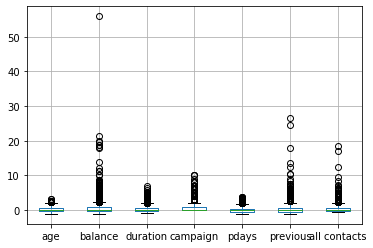

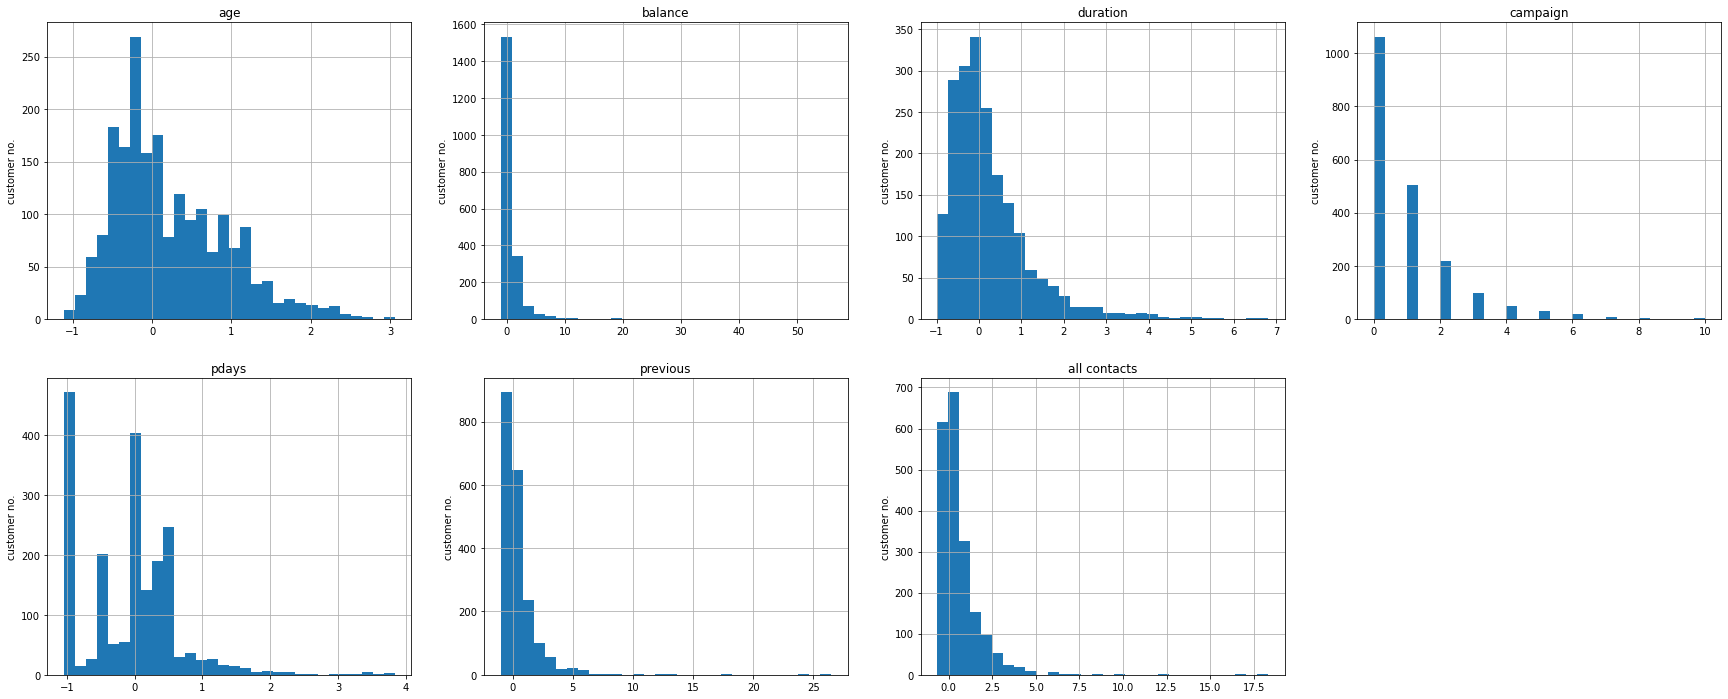

In [473]:
df.boxplot(column=num_cols)
plt.show()
plot_numerical_cols()


In [474]:
for col in num_cols:
    min = df[col].min()
    shift = round_up(abs(min), 4) + 1 if min < 0 else 1 - min
    df[col] = np.log(df[col] + shift)


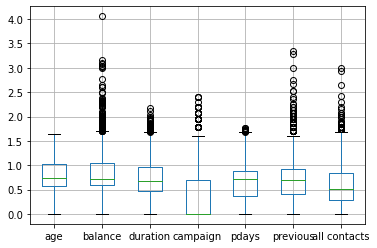

In [475]:
df.boxplot(column=num_cols)
plt.show()
plot_numerical_cols()


In [476]:
# save file to currect folder
df.to_csv('bank_prepared.csv')
